## 2. Análisis de opiniones sobre películas

### a) Construcción del Dataframe

In [1]:
import urllib
import pandas as pd
train_data_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.train"
test_data_url = "http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.dev"
train_data_f = urllib.urlretrieve(train_data_url, "train_data.csv")
test_data_f = urllib.urlretrieve(test_data_url, "test_data.csv")
ftr = open("train_data.csv", "r")
fts = open("test_data.csv", "r")
rows = [line.split(" ",1) for line in ftr.readlines()]
train_df = pd.DataFrame(rows, columns=['Sentiment','Text'])
train_df['Sentiment'] = pd.to_numeric(train_df['Sentiment'])
rows = [line.split(" ",1) for line in fts.readlines()]
test_df = pd.DataFrame(rows, columns=['Sentiment','Text'])
test_df['Sentiment'] = pd.to_numeric(test_df['Sentiment'])
print train_df.shape
print test_df.shape

(3554, 2)
(3554, 2)


Tanto el conjunto de entrenamiento como el de pruebas, poseen 3554 registros para cada clase. Dichas clases se llaman "Sentiment" y "Text"

### b) Función word_extractor

La función word_extractor utiliza stemming para la extracción de trozos de textos de una frase. El stemming es un proceso heurístico que corta la derivación de las palabras para encontrar la raíz. Por ejemplo autómata, automático, automatizado se reducen a autómata.

In [2]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer
def word_extractor(text, stemming=True):
    if stemming is True:
        wordstemmer = PorterStemmer()
        commonwords = stopwords.words('english')
        text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
        words = ""
        wordtokens = [ wordstemmer.stem(word.lower()) for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
        for word in wordtokens:
            if word not in commonwords:
                words+=" "+word
        return words
    else:
        commonwords = stopwords.words('english')
        text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
        words = ""
        wordtokens = [ word.lower() for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
        for word in wordtokens:
            if word not in commonwords:
                words+=" "+word
        return words
        
#Con stemming
print word_extractor("I love to eat cake")
print word_extractor("I love eating cake")
print word_extractor("I loved eating the cake")
print word_extractor("I do not love eating cake")
print word_extractor("I don't love eating cake")

 love eat cake
 love eat cake
 love eat cake
 love eat cake
 n't love eat cake


Lo que se presenta es la extracción de trozos de texto en una frase. Al usar stemming para dicha tarea se puede apreciar en el output que se muestra la tarea en presente simple, lo que muestra que el stemming usa un vocabulario reducido al ignorar palabras como "eating" y "loved", ya que éstas no corresponden al presente simple.

In [3]:
#Sin stemming
print word_extractor("I love to eat cake", stemming=False)
print word_extractor("I love eating cake", stemming=False)
print word_extractor("I loved eating the cake", stemming=False)
print word_extractor("I do not love eating cake", stemming=False)
print word_extractor("I don't love eating cake", stemming=False)

 love eat cake
 love eating cake
 loved eating cake
 love eating cake
 n't love eating cake


Ahora se ejecutó word_extractor sin usar stemming y se puede apreciar que muestra las palabras exactas, lo que se puede concluir que sin usar stemming se obtiene resultados mejores que con stemming debido a que no se redujo el vocabulario sin el uso de stemming.

En resumen, si se consideran los textos “I love eating cake” y “I loved eating the cake”, con stemming se consigue “love eat cake” para ambos casos, mientras que sin stemming se obtiene “love eating cake” y “loved eating cake”.

### c) Función word_extractor2

La función word_extractor2 utiliza el lematizador para extraer trozos de texto de una frase. La lematización es bastante similar al stemming, en el sentido que reducen las formas infleccionales de las palabras a una base común o raíz. Pero en el caso de la lematización y a partir de la implementación de *nltk*, se hace un chequeo de la forma reducida en el corpus de *WordNet*. Si no está en este último, se regresa la palabra original. En consecuencia, la lematización es un proceso más complejo que el stemming.

In [4]:
#la variavle stopwords indica si el lematizador usa stopwords.
def word_extractor2(text, stopWords=True):
    wordlemmatizer = WordNetLemmatizer()
    if stopWords is True:
        commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower()) \
                  for word in word_tokenize(text.decode('utf-8','ignore')) ]
    for word in wordtokens:
        if stopWords is True:
            if word not in commonwords:
                words+=" "+word
        else:
            words+=" "+word
    return words
print word_extractor2("I love to eat cake")
print word_extractor2("I love eating cake")
print word_extractor2("I loved eating the cake")
print word_extractor2("I do not love eating cake")
print word_extractor2("I don't love eating cake")

 love eat cake
 love eating cake
 loved eating cake
 love eating cake
 n't love eating cake


Como resultado, a diferencia de la función word_extractor que usaba stemming para poder extraer trozos de palabras de una frase, la función word_extractor2 que usa lematización para dicho objetivo devuelve cada trozo de palabra exacta, lo que permite un uso de vocabulario más amplio que usando stemming. 

### d) CountVectorizer

In [5]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
texts_train = [word_extractor2(text) for text in train_df.Text]
texts_test = [word_extractor2(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()

#Conjunto de entrenamiento
tags_train = []
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))
for tag, count in zip(vocab, dist):
    tags_train.append((count, tag))
    #print count, tag

In [6]:
#Conjunto de pruebas
tags_test = []
dist=list(np.array(features_test.sum(axis=0)).reshape(-1,))
for tag, count in zip(vocab, dist):
    tags_test.append((count, tag))
    #print count, tag

El código que contiene el CountVectorizer tiene como objetivo guardar la cantidad de veces que aparece cierta palabra/número en el conjunto de entrenamiento/prueba. Las palabras más frecuentes en el conjunto de entrenamiento/pruebas son:

In [7]:
#Top 10 palabras más frecuentes conjunto de entrenamiento
tags_train.sort()
tags_train[:] = tags_train[::-1]

print "Palabras más frecuentes del conjunto de entrenaiento:\n"
for i in range(0,10):
    print str(i+1)+") %s (%d)"%(tags_train[i][1], tags_train[i][0])


Palabras más frecuentes del conjunto de entrenaiento:

1) film (566)
2) movie (481)
3) one (246)
4) like (245)
5) ha (224)
6) make (183)
7) story (176)
8) character (163)
9) comedy (145)
10) time (143)


In [8]:
#Top 10 palabras más frecuentes conjunto de entrenamiento
tags_test.sort()
tags_test[:] = tags_test[::-1]

print "Palabras más frecuentes del conjunto de prueba:\n"
for i in range(0,10):
    print str(i+1)+") %s (%d)"%(tags_test[i][1], tags_test[i][0])


Palabras más frecuentes del conjunto de prueba:

1) film (558)
2) movie (540)
3) one (250)
4) ha (238)
5) like (230)
6) story (197)
7) character (175)
8) time (165)
9) make (161)
10) comedy (134)


### e) Desempeño de un clasificador

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
dict_bernoulli_binario = []
dict_multinomial = []
dict_log = []
dict_svm = []
def score_the_model(model,x,y,xt,yt,text):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    print "Training Accuracy %s: %f"%(text,acc_tr)
    print "Test Accuracy %s: %f"%(text,acc_test)
    print "Detailed Analysis Testing Results ..."
    print(classification_report(yt, model.predict(xt), target_names=['+','-']))
    
    #guarda las métricas de cada método para construir gráficos comparativos más adelante.
    precision, recall, fscore, support = precision_recall_fscore_support(yt, model.predict(xt))
    
    if text == 'BernoulliNB':
        dict_bernoulli_binario.append(acc_tr)
        dict_bernoulli_binario.append(acc_test)
        dict_bernoulli_binario.append(np.mean(precision))
        dict_bernoulli_binario.append(np.mean(recall))
        dict_bernoulli_binario.append(np.mean(fscore))
    elif text == 'MULTINOMIAL':
        dict_multinomial.append(acc_tr)
        dict_multinomial.append(acc_test)
        dict_multinomial.append(np.mean(precision))
        dict_multinomial.append(np.mean(recall))
        dict_multinomial.append(np.mean(fscore))
    elif text == 'LOGISTIC':
        dict_log.append(acc_tr)
        dict_log.append(acc_test)
        dict_log.append(np.mean(precision))
        dict_log.append(np.mean(recall))
        dict_log.append(np.mean(fscore))
    elif text == 'SVM':
        dict_svm.append(acc_tr)
        dict_svm.append(acc_test)
        dict_svm.append(np.mean(precision))
        dict_svm.append(np.mean(recall))
        dict_svm.append(np.mean(fscore))

Las métricas que calcula el método classification_report son las siguientes: precision, recall y F1-score, tal y como se muestra en el output generado usando el clasificador Bayesiano Ingenuo/Multinomial.

- Precision es la cantidad de resultados positivos correctos divididos por la cantidad total de resultados positivos
- Recall corresponde a la cantidad de resultados positivos correctos dividido por el número de resultados positivos que se debería obtener.
- El F1-score es el promedio ponderado de recall y precision. La mejor puntuación corresponde a 1 y la peor corresponde a 0. La fórmula para calcular el F1-score es el siguiente:

$$F1 = 2 * \frac{precision * recall}{precision + recall}$$

### f) Clasificador Bayesiano Ingenuo (Binario)

In [10]:
from sklearn.naive_bayes import BernoulliNB
import random
def do_NAIVE_BAYES(x,y,xt,yt):
    model = BernoulliNB()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"BernoulliNB")
    return model

#Lematizador
texts_train = [word_extractor2(text) for text in train_df.Text]
texts_test = [word_extractor2(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()

model=do_NAIVE_BAYES(features_train,labels_train,features_test,labels_test)
test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 15)

for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text

Training Accuracy BernoulliNB: 0.958638
Test Accuracy BernoulliNB: 0.738531
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.73      0.74      1803
          -       0.73      0.75      0.74      1751

avg / total       0.74      0.74      0.74      3554

[ 0.04199754  0.95800246] the plan to make enough into �an inspiring tale of survival wrapped in the heart-pounding suspense of a stylish psychological thriller' has flopped as surely as a souffl� gone wrong .

[ 0.4313423  0.5686577] borrows a bit from the classics " wait until dark " and " extremities " . . . but in terms of its style , the movie is in a class by itself .

[ 0.98459667  0.01540333] unless you come in to the film with a skateboard under your arm , you're going to feel like you weren't invited to the party .

[ 0.83019561  0.16980439] a serious movie with serious ideas . but seriously , folks , it doesn't work .

[ 0.97451387  0.02548613] cassave

In [11]:
#Lematizador sin stopwords
texts_train_stopwords = [word_extractor2(text, stopWords = False) for text in train_df.Text]
texts_test_stopwords = [word_extractor2(text, stopWords = False) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train_stopwords))
features_train = vectorizer.transform(texts_train_stopwords)
features_test = vectorizer.transform(texts_test_stopwords)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()

model=do_NAIVE_BAYES(features_train,labels_train,features_test,labels_test)
test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 15)

for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text

Training Accuracy BernoulliNB: 0.955262
Test Accuracy BernoulliNB: 0.748663
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.76      0.74      0.75      1803
          -       0.74      0.76      0.75      1751

avg / total       0.75      0.75      0.75      3554

[ 0.40157468  0.59842532] as played by ryan gosling , danny is a frighteningly fascinating contradiction .

[ 0.78957893  0.21042107] wonder of wonders -- a teen movie with a humanistic message .

[ 0.24704298  0.75295702] the picture runs a mere 84 minutes , but it's no glance . it's a head-turner -- thoughtfully written , beautifully read and , finally , deeply humanizing .

[ 0.74828258  0.25171742] this is the first film i've ever seen that had no obvious directing involved .

[ 0.00145052  0.99854948] quiet , adult and just about more stately than any contemporary movie this year . . . a true study , a film with a questioning heart and mind that isn't afraid

In [12]:
#Stemming
texts_train_stemming = [word_extractor(text) for text in train_df.Text]
texts_test_stemming = [word_extractor(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train_stopwords))
features_train = vectorizer.transform(texts_train_stemming)
features_test = vectorizer.transform(texts_test_stemming)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()

model=do_NAIVE_BAYES(features_train,labels_train,features_test,labels_test)
test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 15)

for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text

Training Accuracy BernoulliNB: 0.878728
Test Accuracy BernoulliNB: 0.701098
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.68      0.70      1803
          -       0.69      0.73      0.71      1751

avg / total       0.70      0.70      0.70      3554

[ 0.79896113  0.20103887] not even the hanson brothers can save it

[ 0.87653986  0.12346014] absurdities and clich�s accumulate like lint in a fat man's navel .

[ 0.31941688  0.68058312] narc is all menace and atmosphere .

[ 0.96621417  0.03378583] another big , dumb action movie in the vein of xxx , the transporter is riddled with plot holes big enough for its titular hero to drive his sleek black bmw through .

[ 0.03344819  0.96655181] becomes a fascinating study of isolation and frustration that successfully recreates both the physical setting and emotional tensions of the papin sisters .

[ 0.24342471  0.75657529] eight legged freaks ? no big hairy deal .

Como resumen, al usar el Clasificador Bayesiano Ingenuo Binario, se obtuvieron los siguientes resultados:

**Métrica**  | **Lematizador**   |  **Lematizador sin stopwords** | **Stemming**  
  ----------------- | ---------- | -----------------------------  | ------------------  
  Training accuracy | 0.958638   |         0.955262               |  0.878728                   
  Test accuracy     | 0.738531   |         0.748663               |  0.701098              
  Precision         | 0.74       |         0.75                   |  0.70             
  Recall            | 0.74       |         0.75                   |  0.70             
  F1-score          | 0.74       |         0.75                   |  0.70             
  
En términos generales, se obtienen buenos resultados utilizando lematización y stemming, siendo este último un poco mejor. Al trabajar sin stopwords el procesamiento se vuelve más lento al aumentar el vocabulario pero a pesar de eso, se obtienen buenos resultados. Sin embargo, las palabras más frecuentes son artículos, pronombres y preposiciones en su mayoría, lo que causa la pérdida del poder de análisis en los datos. 

### g) Clasificador Bayesiano Ingenuo Multinomial

In [13]:
from sklearn.naive_bayes import MultinomialNB
import random
def do_MULTINOMIAL(x,y,xt,yt):
    model = MultinomialNB()
    model = model.fit(x, y)
    score_the_model(model,x,y,xt,yt,"MULTINOMIAL")
    return model

#Lematizador
texts_train = [word_extractor2(text) for text in train_df.Text]
texts_test = [word_extractor2(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()

model=do_MULTINOMIAL(features_train,labels_train,features_test,labels_test)
test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 15)
for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text

Training Accuracy MULTINOMIAL: 0.959482
Test Accuracy MULTINOMIAL: 0.740782
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.73      0.74      1803
          -       0.73      0.75      0.74      1751

avg / total       0.74      0.74      0.74      3554

[ 0.5015401  0.4984599] 'this movie sucks . '

[ 0.37561196  0.62438804] not the great american comedy , but if you liked the previous movies in the series , you'll have a good time with this one too .

[ 0.82668558  0.17331442] you don't have to be an especially tough grader to give a charitable b-minus to the emperor's club .

[ 0.34138331  0.65861669] bittersweet comedy/drama full of life , hand gestures , and some really adorable italian guys .

[ 0.86048873  0.13951127] it has the right approach and the right opening premise , but it lacks the zest and it goes for a plot twist instead of trusting the material .

[ 0.86144939  0.13855061] a sleek advert for y

In [14]:
#Lematizador sin stopwords
texts_train_stopwords = [word_extractor2(text, stopWords = False) for text in train_df.Text]
texts_test_stopwords = [word_extractor2(text, stopWords = False) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train_stopwords))
features_train = vectorizer.transform(texts_train_stopwords)
features_test = vectorizer.transform(texts_test_stopwords)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()

model=do_MULTINOMIAL(features_train,labels_train,features_test,labels_test)
test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 15)

for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text

Training Accuracy MULTINOMIAL: 0.955543
Test Accuracy MULTINOMIAL: 0.747537
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.75      0.75      1803
          -       0.74      0.74      0.74      1751

avg / total       0.75      0.75      0.75      3554

[ 0.14282098  0.85717902] will probably stay in the shadow of its two older , more accessible qatsi siblings .

[ 0.89031275  0.10968725] yes , i have given this movie a rating of zero . but fans of the show should not consider this a diss . consider it 'perfection . '

[ 0.94201887  0.05798113] lawrence should stick to his day job . he's a better actor than a standup comedian .

[  9.99558318e-01   4.41682403e-04] a tired , unnecessary retread . . . a stale copy of a picture that wasn't all that great to begin with .

[ 0.53648151  0.46351849] does point the way for adventurous indian filmmakers toward a crossover into nonethnic markets .

[ 0.8344256  0.1655744

In [15]:
#Stemming
texts_train_stemming = [word_extractor(text) for text in train_df.Text]
texts_test_stemming = [word_extractor(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train_stopwords))
features_train = vectorizer.transform(texts_train_stemming)
features_test = vectorizer.transform(texts_test_stemming)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()

model=do_MULTINOMIAL(features_train,labels_train,features_test,labels_test)
test_pred = model.predict_proba(features_test)
spl = random.sample(xrange(len(test_pred)), 15)

for text, sentiment in zip(test_df.Text[spl], test_pred[spl]):
    print sentiment, text

Training Accuracy MULTINOMIAL: 0.882949
Test Accuracy MULTINOMIAL: 0.705319
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.71      0.70      0.71      1803
          -       0.70      0.71      0.70      1751

avg / total       0.71      0.71      0.71      3554

[ 0.89626185  0.10373815] for anyone who grew up on disney's 1950 treasure island , or remembers the 1934 victor fleming classic , this one feels like an impostor .

[ 0.49516061  0.50483939] it tells more than it shows .

[ 0.73341015  0.26658985] as broad and cartoonish as the screenplay is , there is an accuracy of observation in the work of the director , frank novak , that keeps the film grounded in an undeniable social realism .

[ 0.91335102  0.08664898] this version of h . g . wells' time machine was directed by h . g . wells' great-grandson . they should have found orson welles' great-grandson .

[ 0.81100419  0.18899581] as vulgar as it is banal .

[ 0.

Como resumen, al usar el Clasificador Bayesiano Ingenuo Multinomial, se obtuvieron los siguientes resultados:

**Métrica**  | **Lematizador**   |  **Lematizador sin stopwords** | **Stemming**  
  ----------------- | ---------- | -----------------------------  | ------------------  
  Training accuracy | 0.959482   |         0.955543               |  0.882949                   
  Test accuracy     | 0.740782   |         0.747537               |  0.705319              
  Precision         | 0.74       |         0.75                   |  0.71             
  Recall            | 0.74       |         0.75                   |  0.71             
  F1-score          | 0.74       |         0.75                   |  0.71             
  
La conclusión que se obtiene a partir de estos resultados es la misma que para el caso del ejercicio f), debida a las mismas razones planteadas anteriormente en dicho ejercicio, es decir, se obtienen buenos resultados utilizando lematización y stemming, siendo este último el que logra un mejor resultado. Al trabajar sin stopwords el efecto que produce es que el procesamiento se vuelve más lento, debido al aumento en el vocabulario pero aún así se obtienen buenos resultados. No obstante, las palabras más frecuentes son artículos, pronombres y preposiciones en su mayoría perdiendo poder de análisis en los datos.

### h) Regresión Logı́stica Regularizado

La regularización permite controlar el efecto de los estimadores en la predicción, es decir, el aporte que tienen
estos. Para el caso del algoritmo de Regresión logística (ocurre lo mismo en SVM lineal) utiliza como parámetro
el valor inverso del parámetro de regularización, por tanto tiene un efecto contrario al habitual. Si la regularización toma un valor bajo (cercano a cero) significa que el aporte de los estimadores en la predicción será alto (la penalización es baja) y si el parámetro toma un valor alto ocurre lo contrario (penalización alta). Entonces, con la regularización adecuada se busca reducir el efecto de overfitting en el modelo predictivo, al reducir o disminuir la participación de los estimadores en el modelo.

In [16]:
from sklearn.linear_model import LogisticRegression
def do_LOGIT(x,y,xt,yt):
    start_t = time.time()
    Cs = [0.01,0.1,10,100,1000]
    for C in Cs:
        print "Usando C= %f"%C
        model = LogisticRegression(penalty='l2',C=C)
        model = model.fit(x, y)
        score_the_model(model,x,y,xt,yt,"LOGISTIC")

#Lematizador
texts_train = [word_extractor2(text) for text in train_df.Text]
texts_test = [word_extractor2(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()
do_LOGIT(features_train,labels_train,features_test,labels_test)

Usando C= 0.010000
Training Accuracy LOGISTIC: 0.784468
Test Accuracy LOGISTIC: 0.678863
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.67      0.73      0.70      1803
          -       0.69      0.63      0.66      1751

avg / total       0.68      0.68      0.68      3554

Usando C= 0.100000
Training Accuracy LOGISTIC: 0.892234
Test Accuracy LOGISTIC: 0.719111
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.72      0.72      1803
          -       0.72      0.71      0.71      1751

avg / total       0.72      0.72      0.72      3554

Usando C= 10.000000
Training Accuracy LOGISTIC: 1.000000
Test Accuracy LOGISTIC: 0.718548
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.72      0.72      1803
          -       0.71      0.72      0.72      1751

avg / total       0.72     

In [17]:
#Lematizador sin stopwords
texts_train_stopwords = [word_extractor2(text, stopWords = False) for text in train_df.Text]
texts_test_stopwords = [word_extractor2(text, stopWords = False) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train_stopwords))
features_train = vectorizer.transform(texts_train_stopwords)
features_test = vectorizer.transform(texts_test_stopwords)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()
do_LOGIT(features_train,labels_train,features_test,labels_test)

Usando C= 0.010000
Training Accuracy LOGISTIC: 0.734102
Test Accuracy LOGISTIC: 0.671827
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.68      0.68      0.68      1803
          -       0.67      0.66      0.67      1751

avg / total       0.67      0.67      0.67      3554

Usando C= 0.100000
Training Accuracy LOGISTIC: 0.879572
Test Accuracy LOGISTIC: 0.718548
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.72      0.72      1803
          -       0.71      0.72      0.72      1751

avg / total       0.72      0.72      0.72      3554

Usando C= 10.000000
Training Accuracy LOGISTIC: 1.000000
Test Accuracy LOGISTIC: 0.731495
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.74      0.72      0.73      1803
          -       0.72      0.75      0.73      1751

avg / total       0.73     

In [18]:
#Stemming
texts_train_stemming = [word_extractor(text) for text in train_df.Text]
texts_test_stemming = [word_extractor(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train_stopwords))
features_train = vectorizer.transform(texts_train_stemming)
features_test = vectorizer.transform(texts_test_stemming)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()
do_LOGIT(features_train,labels_train,features_test,labels_test)

Usando C= 0.010000
Training Accuracy LOGISTIC: 0.723129
Test Accuracy LOGISTIC: 0.654095
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.64      0.72      0.68      1803
          -       0.67      0.58      0.62      1751

avg / total       0.66      0.65      0.65      3554

Usando C= 0.100000
Training Accuracy LOGISTIC: 0.814856
Test Accuracy LOGISTIC: 0.689840
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.69      0.71      0.70      1803
          -       0.69      0.67      0.68      1751

avg / total       0.69      0.69      0.69      3554

Usando C= 10.000000
Training Accuracy LOGISTIC: 0.977209
Test Accuracy LOGISTIC: 0.668731
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.67      0.67      0.67      1803
          -       0.66      0.67      0.66      1751

avg / total       0.67     

Se obtienen las métricas relacionadas al aplicar un modelo de Regresión Logística Regularizado, penalizando con
normal $l_{2}$ y parámetro de regularización C = 0,1, para los diferentes casos solicitados.

**Métrica**  | **Lematizador**   |  **Lematizador sin stopwords** | **Stemming**  
  ----------------- | ---------- | -----------------------------  | ------------------  
  Training accuracy | 0.892234   |         0.879572               |  0.814856                   
  Test accuracy     | 0.719111   |         0.718548               |  0.689840              
  Precision         | 0.72       |         0.72                   |  0.73             
  Recall            | 0.72       |         0.72                   |  0.73             
  F1-score          | 0.72       |         0.72                   |  0.73             
  
Como se puede apreciar, la conclusión es la misma que se realizó en las preguntas f) y g) debida a las mismas razones planteadas en tales preguntas, es decir, nuevamente se obtienen buenos resultados utilizando lematización y stemming, siendo este último el que logra un resultado mejor. Al eliminar la técnica de stopwords el efecto que produce es que el procesamiento se vuelve más lento, debido al aumento en el vocabulario, pero aún así se obtienen buenos resultados. No obstante, las palabras más frecuentes son en su mayoría artículos, pronombres y preposiciones perdiendo poder de análisis en los datos.

### i) Máquina de Vectores de Soporte (SVM) Lineal

In [19]:
from sklearn.svm import LinearSVC
def do_SVM(x,y,xt,yt):
    Cs = [0.01,0.1,10,100,1000]
    for C in Cs:
        print "El valor de C que se esta probando: %f"%C
        model = LinearSVC(C=C)
        model = model.fit(x, y)
        score_the_model(model,x,y,xt,yt,"SVM")

#Lematizador
texts_train = [word_extractor2(text) for text in train_df.Text]
texts_test = [word_extractor2(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_test = vectorizer.transform(texts_test)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()
do_SVM(features_train,labels_train,features_test,labels_test)

El valor de C que se esta probando: 0.010000
Training Accuracy SVM: 0.884637
Test Accuracy SVM: 0.715170
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.72      0.72      1803
          -       0.71      0.71      0.71      1751

avg / total       0.72      0.72      0.72      3554

El valor de C que se esta probando: 0.100000
Training Accuracy SVM: 0.989589
Test Accuracy SVM: 0.723614
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.72      0.73      1803
          -       0.72      0.73      0.72      1751

avg / total       0.72      0.72      0.72      3554

El valor de C que se esta probando: 10.000000
Training Accuracy SVM: 1.000000
Test Accuracy SVM: 0.702786
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.71      0.69      0.70      1803
          -       0.69      0.71 

In [20]:
#Lematizador sin stopwords
texts_train_stopwords = [word_extractor2(text, stopWords = False) for text in train_df.Text]
texts_test_stopwords = [word_extractor2(text, stopWords = False) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train_stopwords))
features_train = vectorizer.transform(texts_train_stopwords)
features_test = vectorizer.transform(texts_test_stopwords)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()
do_SVM(features_train,labels_train,features_test,labels_test)

El valor de C que se esta probando: 0.010000
Training Accuracy SVM: 0.873382
Test Accuracy SVM: 0.719111
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.72      0.72      0.72      1803
          -       0.71      0.72      0.72      1751

avg / total       0.72      0.72      0.72      3554

El valor de C que se esta probando: 0.100000
Training Accuracy SVM: 0.987901
Test Accuracy SVM: 0.738249
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.75      0.73      0.74      1803
          -       0.73      0.75      0.74      1751

avg / total       0.74      0.74      0.74      3554

El valor de C que se esta probando: 10.000000
Training Accuracy SVM: 1.000000
Test Accuracy SVM: 0.713763
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.73      0.69      0.71      1803
          -       0.70      0.74 

In [21]:
#Stemming
texts_train_stemming = [word_extractor(text) for text in train_df.Text]
texts_test_stemming = [word_extractor(text) for text in test_df.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train_stopwords))
features_train = vectorizer.transform(texts_train_stemming)
features_test = vectorizer.transform(texts_test_stemming)
labels_train = np.asarray((train_df.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((test_df.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()
do_SVM(features_train,labels_train,features_test,labels_test)

El valor de C que se esta probando: 0.010000
Training Accuracy SVM: 0.808385
Test Accuracy SVM: 0.688432
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.69      0.71      0.70      1803
          -       0.69      0.67      0.68      1751

avg / total       0.69      0.69      0.69      3554

El valor de C que se esta probando: 0.100000
Training Accuracy SVM: 0.921497
Test Accuracy SVM: 0.698283
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.70      0.70      0.70      1803
          -       0.69      0.70      0.69      1751

avg / total       0.70      0.70      0.70      3554

El valor de C que se esta probando: 10.000000
Training Accuracy SVM: 0.991559
Test Accuracy SVM: 0.650155
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.65      0.66      0.66      1803
          -       0.65      0.64 

Se obtienen las métricas relacionadas al aplicar SVM lineal, con un parámetro de regularización de C = 0,1,
para los diferentes casos solicitados.

**Métrica**  | **Lematizador**   |  **Lematizador sin stopwords** | **Stemming**  
  ----------------- | ---------- | -----------------------------  | ------------------  
  Training accuracy | 0.989589   |         0.987901               |  0.921497                   
  Test accuracy     | 0.723614   |         0.738249               |  0.698283              
  Precision         | 0.72       |         0.74                   |  0.70             
  Recall            | 0.72       |         0.74                   |  0.70             
  F1-score          | 0.72       |         0.74                   |  0.70             
  
Nuevamente se obtienen buenos resultados utilizando lematización y stemming, siendo este último el que logra un resultado mejor. Al eliminar la técnica de stopwords el procesamiento se produce un efecto más lento en su ejecución, debido al aumento en el vocabulario pero, el resultado mejora un poco debido a este aumento de información. Sin embargo, las palabras más frecuentes son en su mayoría artículos, pronombres y preposiciones perdiendo poder de análisis en los datos.

### j) Comparando resultados métodos de clasificación

Se comparan los diferentes métodos de clasificación vistos de acuerdo a las métricas: accuracy, precisión, recall
y f1-score, con las técnicas de *lematización* y *stemming*. Para esto se construye un gráfico de barras que permita hacer dicha comparación.

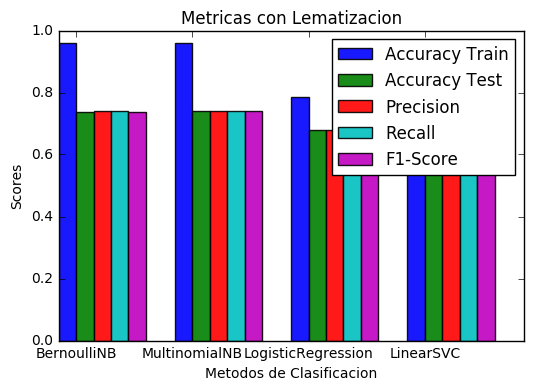

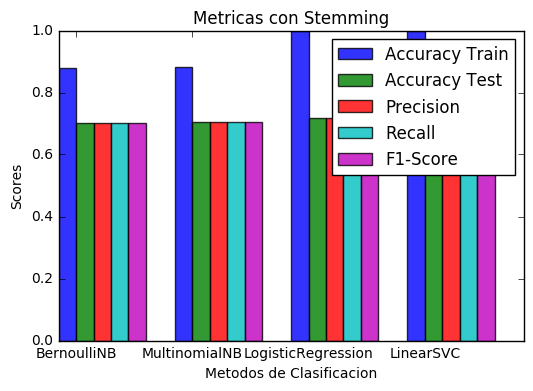

In [35]:
import matplotlib.pyplot as plt

#Lematización
accuracy_train = []
accuracy_test = []
precision = []
recall = []
fscore = []

#Guarda las metricas correspondientes en cada método
accuracy_train.append(dict_bernoulli_binario[0])
accuracy_train.append(dict_multinomial[0])
accuracy_train.append(dict_log[0])
accuracy_train.append(dict_svm[0])

accuracy_test.append(dict_bernoulli_binario[1])
accuracy_test.append(dict_multinomial[1])
accuracy_test.append(dict_log[1])
accuracy_test.append(dict_svm[1])

precision.append(dict_bernoulli_binario[2])
precision.append(dict_multinomial[2])
precision.append(dict_log[2])
precision.append(dict_svm[2])

recall.append(dict_bernoulli_binario[3])
recall.append(dict_multinomial[3])
recall.append(dict_log[3])
recall.append(dict_svm[3])

fscore.append(dict_bernoulli_binario[4])
fscore.append(dict_multinomial[4])
fscore.append(dict_log[4])
fscore.append(dict_svm[4])

fig, ax = plt.subplots()
index = np.arange(4)
bar_width = 0.15
opacity = 0.9
 
rects1 = plt.bar(index, accuracy_train, bar_width,alpha=opacity,color='b',label='Accuracy Train')
rects2 = plt.bar(index + bar_width, accuracy_test, bar_width,alpha=opacity,color='g',label='Accuracy Test')
rects3 = plt.bar(index + 2*bar_width, precision, bar_width,alpha=opacity,color='r',label='Precision')
rects4 = plt.bar(index + 3*bar_width, recall, bar_width,alpha=opacity,color='c',label='Recall')
rects5 = plt.bar(index + 4*bar_width, fscore, bar_width,alpha=opacity,color='m',label='F1-Score')
plt.xlabel('Metodos de Clasificacion')
plt.ylabel('Scores')
plt.title('Metricas con Lematizacion')
plt.xticks(index + bar_width, ('BernoulliNB', 'MultinomialNB', 'LogisticRegression', 'LinearSVC'))
plt.legend()

#Stemming
accuracy_train = []
accuracy_test = []
precision = []
recall = []
fscore = []

#Guarda las metricas correspondientes en cada método
accuracy_train.append(dict_bernoulli_binario[10])
accuracy_train.append(dict_multinomial[10])
accuracy_train.append(dict_log[10])
accuracy_train.append(dict_svm[10])

accuracy_test.append(dict_bernoulli_binario[11])
accuracy_test.append(dict_multinomial[11])
accuracy_test.append(dict_log[11])
accuracy_test.append(dict_svm[11])

precision.append(dict_bernoulli_binario[12])
precision.append(dict_multinomial[12])
precision.append(dict_log[12])
precision.append(dict_svm[12])

recall.append(dict_bernoulli_binario[13])
recall.append(dict_multinomial[13])
recall.append(dict_log[13])
recall.append(dict_svm[13])

fscore.append(dict_bernoulli_binario[14])
fscore.append(dict_multinomial[14])
fscore.append(dict_log[14])
fscore.append(dict_svm[14])

fig, ax = plt.subplots()
index = np.arange(4)
bar_width = 0.15
opacity = 0.8
 
rects1 = plt.bar(index, accuracy_train, bar_width,alpha=opacity,color='b',label='Accuracy Train')
rects2 = plt.bar(index + bar_width, accuracy_test, bar_width,alpha=opacity,color='g',label='Accuracy Test')
rects3 = plt.bar(index + 2*bar_width, precision, bar_width,alpha=opacity,color='r',label='Precision')
rects4 = plt.bar(index + 3*bar_width, recall, bar_width,alpha=opacity,color='c',label='Recall')
rects5 = plt.bar(index + 4*bar_width, fscore, bar_width,alpha=opacity,color='m',label='F1-Score')
 
plt.xlabel('Metodos de Clasificacion')
plt.ylabel('Scores')
plt.title('Metricas con Stemming')
plt.xticks(index + bar_width, ('BernoulliNB', 'MultinomialNB', 'LogisticRegression', 'LinearSVC'))
plt.legend()

#mostrar gráficos
plt.show()

En ambos gráficos se puede observar que los cuatro métodos tienen un comportamiento similar obteniendo buenos resultados (*accuracy*, *precisión*, *recall* y *f1-score* > 70). Se puede observar que el método que obtiene mejores resultados es el *clasificador Bayesiano Ingenuo Multinomial*. No obstante, para el modelo de *Regresión logística* y *SVM lineal* no se realizo un estudio exhaustivo del parámetro de regulación a utilizar, por lo que con un regularizador más adecuado podría mejorar sus resultados, aún cuando éstos ya son buenos.